In [1]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.ndimage import gaussian_filter1d

import os
import sys
sys.path.append('..')
from utils.fit import fit_bms
from utils.viz import viz 
from utils.analyze import *
from utils.model import *
viz.get_style()
pth = os.path.abspath(os.getcwd())+'/..'


In [2]:
method = 'map'    
data_set = 'exp1data'
models = ['MOS6', 'FLR6', 'RS3', 'PH4',
          'MOS22', 'FLR22', 'RS13', 'PH17']

## Model comparison

In [3]:
def get_llh_score(data_set, models, method):
    '''Get likelihood socres

    Inputs:
        models: a list of models for evaluation
    
    Outputs:
        crs: nll, aic and bic score per model per particiant
        pxp: pxp score per model per particiant
    '''
    tar = models[0]
    fit_sub_info = []
    for i, m in enumerate(models):
        with open(f'{pth}/fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
            fit_info = pickle.load(handle)
        # get the subject list 
        valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
        if i==0: subj_lst = valid_sub_lst
        # get log post
        log_post = [fit_info[idx]['log_post'] for idx in subj_lst]
        bic      = [fit_info[idx]['bic'] for idx in subj_lst]
        h        = [fit_info[idx]['H'] for idx in subj_lst]
        n_param  = fit_info[list(subj_lst)[0]]['n_param']
        fit_sub_info.append({
            'log_post': log_post, 
            'bic': bic, 
            'n_param': n_param, 
            'H': h,
        })
    # get bms 
    bms_results = fit_bms(fit_sub_info, use_bic=False)

    ## combine into a dataframe 
    cols = ['NLL', 'AIC', 'BIC', 'model', 'sub_id']
    crs = {k: [] for k in cols}
    for m in models:
        with open(f'{pth}/fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
            fit_info = pickle.load(handle)
        # get the subject list 
        if i==0: subj_lst = fit_info.keys() 
        # get log post
        nll = [-fit_info[idx]['log_like'] for idx in subj_lst]
        aic = [fit_info[idx]['aic'] for idx in subj_lst]
        bic = [fit_info[idx]['bic'] for idx in subj_lst]
        bic = [fit_info[idx]['bic'] for idx in subj_lst]
        crs['NLL'] += nll
        crs['AIC'] += aic
        crs['BIC'] += bic
        crs['model'] += [m]*len(nll)
        crs['sub_id'] += list(subj_lst)
    crs = pd.DataFrame.from_dict(crs)
    for c in ['NLL', 'BIC', 'AIC']:
        tar_crs = len(models)*list(crs.query(f'model=="{tar}"')[c].values)
        crs[c] -= tar_crs
    pxp = pd.DataFrame.from_dict({'pxp': bms_results['pxp'], 'model': models})

    return crs, pxp 

In [4]:
crs, pxp = get_llh_score(data_set, models, method)

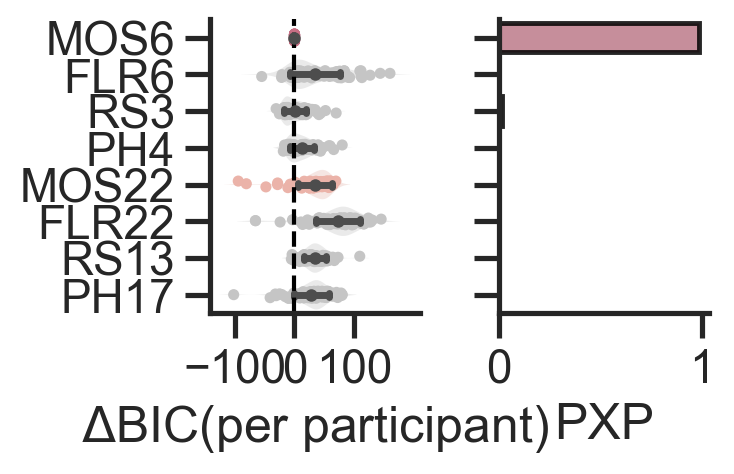

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(4, 8))
for fi, x_var in enumerate(['BIC']):
        ax = axs[fi]
        #x_var = 'BIC'
        tar   = 'model'
        palette = [eval(m).color for m in models]
        viz.violin(data=crs, x=x_var, y='model', 
                    order=models, orient='h', palette=palette,
                    scatter_size=4,
                    mean_marker_size=4.5, 
                    errorbar='sd',
                    ax=ax)
        ax.axvline(x=0, ymin=0, ymax=1, color='k', ls='--', lw=1.5)
        lbl = [eval(m).name for m in models]
        # lbl.pop(0)
        # lbl.insert(0, 'Target: EU+MO+HA')
        ax.set_yticks(list(range(len(models))))
        ax.set_yticklabels(lbl) if fi==0 else ax.set_yticklabels('')
        ax.set_xticks([-100, 0, 100])
        ax.set_xlabel(r'$\Delta$'+f'{x_var}(per participant)')
        ax.set_ylabel('')
        ax.set_box_aspect(1.4)
ax=axs[1]
sns.barplot(x='pxp', y=tar, data=pxp, 
            hue=tar, 
            linewidth=1.75, palette=palette,
            edgecolor=(0,0,0,0), alpha=.85,
            ax=ax)
ax.set_yticks(list(range(len(models))))
ax.set_yticklabels('')
ax.set_xlabel(r'PXP')
ax.set_ylabel('')
ax.set_box_aspect(1.4)
fig.tight_layout()
plt.savefig('../figures/Fig2_model_comp.pdf', dpi=300)

## Model hit rate 

In [6]:
def get_hit_rate(models):
    comb_data = []
    for m in models:
        tar = 'hit'
        fname = f'../adv/{m}.csv'
        valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
        data = pd.read_csv(fname).query(f'sub_id in {valid_sub_lst}')
        sel_data = data.groupby(by=['sub_id', 'group'])[['hit']].mean().reset_index()
        sel_data['log_hit'] = np.log(sel_data['hit'])
        x_data = sel_data.query('group=="HC"')[tar]
        y_data = sel_data.query('group=="PAT"')[tar]
        print(f'# ------------------- {m} ------------------ #')
        print(f'\tHC: {np.mean(x_data):.3f}+-{np.std(x_data):.3f}')
        print(f'\tPAT: {np.mean(y_data):.3f}+-{np.std(y_data):.3f}')
        t_test(x_data, y_data)
        sel_data = data.groupby(by=['sub_id', 'group'])[['hit']].mean().reset_index()
        sel_data['model'] = m
        comb_data.append(sel_data)
    comb_data = pd.concat(comb_data, axis=0)
    return comb_data

In [12]:
models = ['human', 'MOS6', 'MOS22', 'FLR6', 'FLR22', 'RS3', 'RS13', 'PH4', 'PH17']
comb_data = get_hit_rate(models)

# ------------------- human ------------------ #
	HC: 0.581+-0.058
	PAT: 0.540+-0.052
 	t(70.541)=3.326, p=0.001, cohen-d=0.723
# ------------------- MOS6 ------------------ #
	HC: 0.560+-0.040
	PAT: 0.533+-0.038
 	t(67.237)=3.173, p=0.002, cohen-d=0.701
# ------------------- MOS22 ------------------ #
	HC: 0.566+-0.044
	PAT: 0.541+-0.038
 	t(71.954)=2.766, p=0.007, cohen-d=0.597
# ------------------- FLR6 ------------------ #
	HC: 0.498+-0.017
	PAT: 0.499+-0.023
 	t(51.520)=-0.148, p=0.883, cohen-d=0.036
# ------------------- FLR22 ------------------ #
	HC: 0.558+-0.041
	PAT: 0.535+-0.042
 	t(63.090)=2.376, p=0.021, cohen-d=0.536
# ------------------- RS3 ------------------ #
	HC: 0.565+-0.045
	PAT: 0.536+-0.040
 	t(71.708)=3.129, p=0.003, cohen-d=0.676
# ------------------- RS13 ------------------ #
	HC: 0.573+-0.047
	PAT: 0.543+-0.044
 	t(68.453)=2.902, p=0.005, cohen-d=0.637
# ------------------- PH4 ------------------ #
	HC: 0.570+-0.049
	PAT: 0.537+-0.040
 	t(75.416)=3.299, p=0.0

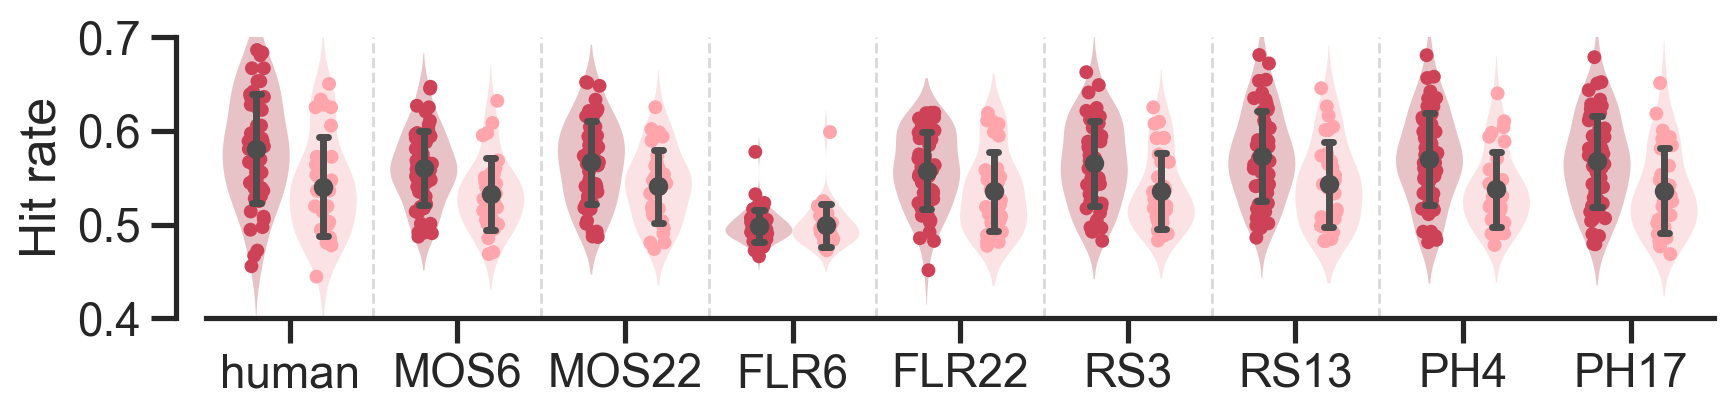

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.4), sharey=True)
viz.violin(ax, data=comb_data, y='hit', 
                x='model', order=models, 
                hue='group', hue_order=['HC', 'PAT'],
                errorbar='sd', scatter_size=5,
                palette=viz.PurplePairs, mean_marker_size=7)
ax.legend().remove()
#ax.set_box_aspect(1.4)
ax.set_ylabel('Hit rate')
ax.set_xlabel('')
ax.set_ylim([.4, .7])
ax.spines['left'].set_position(('axes',-0.02))
lines = np.arange(len(models)-2)+.5
for l in lines:
    ax.axvline(x=l, ymin=0, ymax=1, color=[.85]*3, lw=1, ls='--')
fig.tight_layout()
plt.savefig('../figures/Fig3C_hit_rates.pdf', dpi=300)

## Model hit rate differences

In [14]:
def get_hit_rate_difference(models):
    data = []
    for m in models:
        fname = f'../adv/{m}.csv'
        valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
        datum = pd.read_csv(fname).query(f'sub_id in {valid_sub_lst}')
        sel_data = datum.groupby(by=['sub_id', 'trial_type', 'group'])[['hit', 'g']].mean().reset_index()
        p_table  = sel_data.pivot_table(
                        columns='trial_type',
                        index=['sub_id', 'group'],
                        values='hit',
                        aggfunc='mean',
                    ).reset_index()
        p_table['adaptation'] = p_table['vol'] - p_table['sta']
        # t-test
        print(f'# ------------------- {m} ------------------ #')
        x_data = p_table.query('group=="HC"')['adaptation']
        y_data = p_table.query('group=="PAT"')['adaptation']
        t_test(x_data, y_data)
        comb_data = p_table.merge(sel_data, on=['sub_id', 'group'], how='left').groupby(
            by=['sub_id', 'group'])[['g', 'adaptation']].mean().reset_index()
        comb_data['model'] = m 
        data.append(comb_data)
    data = pd.concat(data, axis=0)
    return data 

In [15]:
models = ['human', 'MOS6', 'MOS22', 'FLR6', 'FLR22', 'RS3', 'RS13', 'PH4', 'PH17']
comb_data = get_hit_rate_difference(models)

# ------------------- human ------------------ #
 	t(55.648)=2.038, p=0.046, cohen-d=0.478
# ------------------- MOS6 ------------------ #
 	t(76.807)=1.890, p=0.063, cohen-d=0.398
# ------------------- MOS22 ------------------ #
 	t(53.312)=1.733, p=0.089, cohen-d=0.412
# ------------------- FLR6 ------------------ #
 	t(67.948)=0.039, p=0.969, cohen-d=0.009
# ------------------- FLR22 ------------------ #
 	t(74.782)=0.186, p=0.853, cohen-d=0.040
# ------------------- RS3 ------------------ #
 	t(73.081)=3.073, p=0.003, cohen-d=0.660
# ------------------- RS13 ------------------ #
 	t(65.570)=0.397, p=0.693, cohen-d=0.088
# ------------------- PH4 ------------------ #
 	t(71.553)=3.977, p=0.000, cohen-d=0.860
# ------------------- PH17 ------------------ #
 	t(53.282)=0.871, p=0.388, cohen-d=0.207


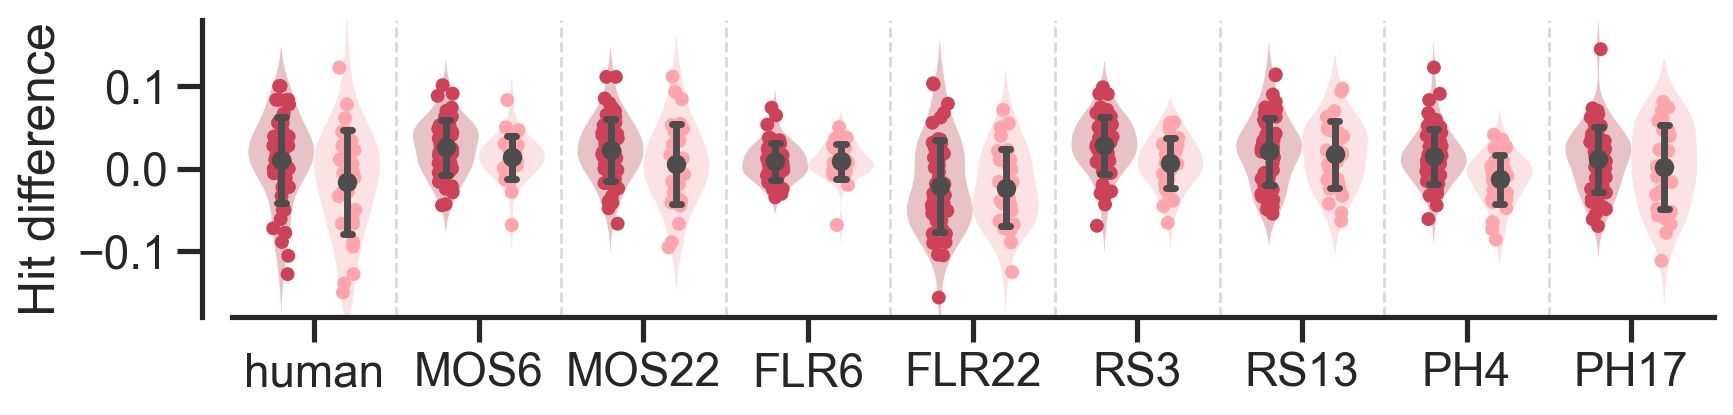

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.4), sharey=True)
viz.violin(ax, data=comb_data, y='adaptation', 
            x='model', order=models, 
            hue='group', hue_order=['HC', 'PAT'],
            errorbar='sd', scatter_size=5,
            palette=viz.PurplePairs, mean_marker_size=7)
#ax.set_box_aspect(1.4)
ax.legend().remove()
ax.set_ylabel('Hit difference')
ax.set_xlabel('')
ax.set_ylim([-.18, .18])
ax.set_yticks([-.1, 0, .1])
ax.spines['left'].set_position(('axes',-0.02))
lines = np.arange(len(models)-1)+.5
for l in lines: ax.axvline(x=l, ymin=0, ymax=1, color=[.85]*3, lw=1, ls='--')
fig.tight_layout()
plt.savefig('../figures/Fig3D_hit_differences.pdf', dpi=300)

## Model learning curves

In [32]:
def get_a_remap(block_data):
    psi_type = block_data['psi_type'].unique()[0]
    if psi_type=='vol8-sta3':
        block1 = 1-block_data['a'].values[90:]
        block2 = 1-block_data['a'].values[:90]
    elif psi_type=='sta3-vol8':
        block1 = 1-block_data['a'].values[:90]
        block2 = 1-block_data['a'].values[90:]
    elif psi_type=='vol2-sta7': 
        block1 = block_data['a'].values[90:]
        block2 = block_data['a'].values[:90]
    elif psi_type=='sta7-vol2':
        block1 = block_data['a'].values[:90]
        block2 = block_data['a'].values[90:]
    a_remap = np.hstack([block1, block2])
    if block_data['feedback_type'].unique()[0]=='loss':
        a_remap = 1 - a_remap
    block_data['a_remap'] = a_remap
    block_data['trial']   = np.arange(0, 180)
    return block_data

In [33]:
def get_lr_curve(ax, m):
    valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
    fname = f'../simulations/exp1data/{m}/sim-map.csv'
    data = pd.read_csv(fname).query(f'sub_id in {valid_sub_lst}')
    remap_data = [] 
    sub_lst = data['sub_id'].unique()
    for sub_id in sub_lst:
        sub_data = data.query(f'sub_id=="{sub_id}"')
        block_lst = sub_data['block_id'].unique()
        for block_id in block_lst:
            sel_data = sub_data.query(f'block_id=={block_id}')
            sim_lst = sel_data['sim_id'].unique()
            for sim_id in sim_lst:
                block_data = sel_data.query(f'sim_id=="{sim_id}"').reset_index()
                block_data = get_a_remap(block_data)
                remap_data.append(block_data)
    remap_data = pd.concat(remap_data, axis=0)
    remap_data['group'] = remap_data['group'].map({'HC': 'HC', 'MDD': 'PAT', 'GAD': 'PAT'})
    psi  = np.zeros([180])
    psi[:90]     = .75
    psi[90:110]  = .2
    psi[110:130] = .8
    psi[130:150] = .2
    psi[150:170] = .8
    psi[170:180] = .2
    sel_data = remap_data.groupby(by=['trial', 'group'])['a_remap'].mean().reset_index()
    smooth_data = {'a': [], 'group': [], 'trial': []}
    for g in ['HC', 'PAT']:
        smooth = gaussian_filter1d(sel_data.query(f'group=="{g}"')['a_remap'], sigma=2)
        n = smooth.shape[0]
        smooth_data['a'] += smooth.tolist()
        smooth_data['group'] += [g]*n
        smooth_data['trial'] += list(range(1, n+1))
    smooth_data = pd.DataFrame.from_dict(smooth_data)
    sns.lineplot(x='trial', y='a', data=smooth_data,
                hue='group', hue_order=['HC', 'PAT'], palette=viz.PurplePairs,
                lw=3.75,
                ax=ax)
    sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--', lw=1.25, ax=ax, zorder=-10)
    ax.set_box_aspect(.45)
    ax.spines['left'].set_position(('axes',-0.03))
    ax.set_ylim([.1, .9])
    ax.set_yticks([.2, .4, .6, .8])
    ax.set_xticks([1, 45, 90, 135, 180])
    ax.set_xlabel('Trial')

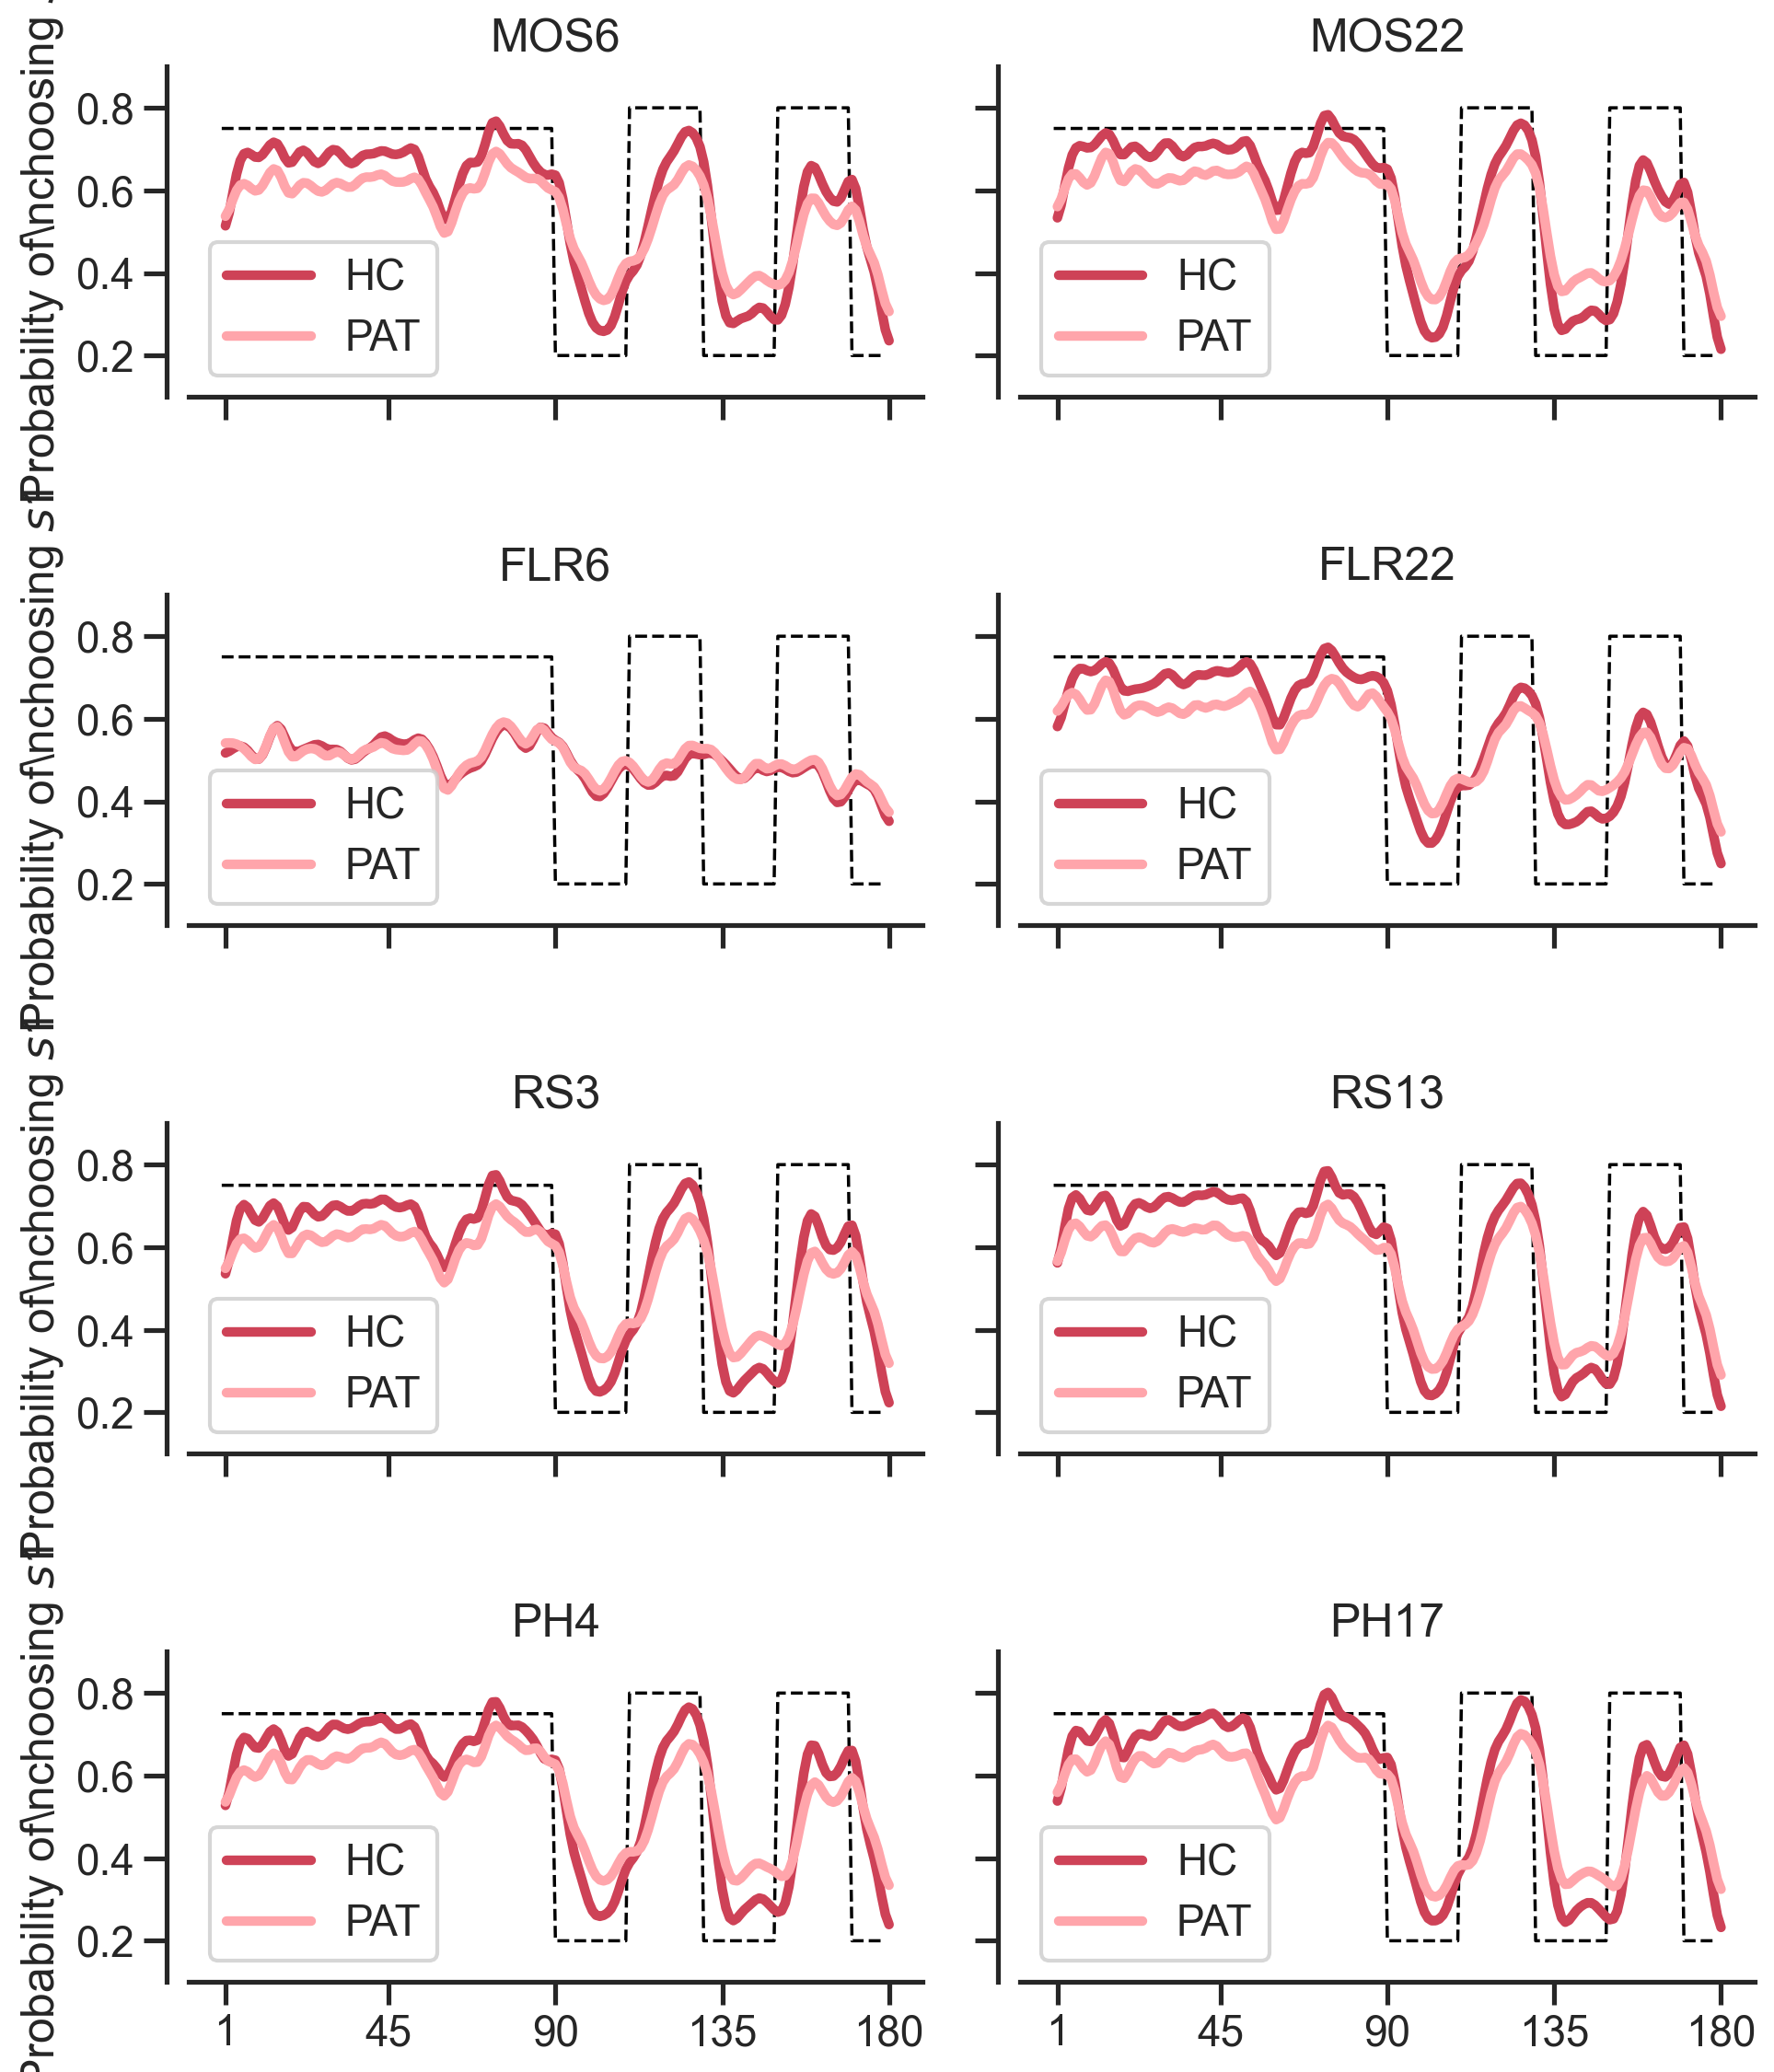

In [34]:
fig, axs = plt.subplots(4, 2, figsize=(10, 12), sharey=True, sharex=True)
for i, m in enumerate(['MOS6', 'MOS22', 'FLR6', 'FLR22', 'RS3', 'RS13', 'PH4', 'PH17']):
    ax = axs[i//2, i%2]
    get_lr_curve(ax, m)
    ylbl = '' if i%2>0 else r'Probability of\nchoosing $s$1'
    ax.set_ylabel(ylbl)
    ax.set_title(m)
    xlbl = '' if i//2==3 else 'Trial'
    ax.set_xlabel(xlbl)
fig.tight_layout()
plt.savefig('../figures/FigS4_learn_curve.pdf', dpi=300)

## Figure3-figure supplement 1

In [20]:
method = 'map'    
data_set = 'exp1data'
models = ['MOS6',
          'EU_MO', 'EU_HA', 'MO_HA', 
          'PS_MO_HA', 'EU_RD_HA',
          'EU_PS_MO_HA', 'EU_MO_HA_RD',
          'MOS22',
          'EU_MO18', 'EU_HA18', 'MO_HA18', 
          'PS_MO_HA22', 
          'EU_PS_MO_HA26']
tar = models[0]

In [21]:
## get BMS
fit_sub_info = []
for i, m in enumerate(models):
    with open(f'{pth}/fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
        fit_info = pickle.load(handle)
    # get the subject list 
    if i==0: subj_lst = fit_info.keys() 
    # get log post
    log_post = [fit_info[idx]['log_post'] for idx in subj_lst]
    bic      = [fit_info[idx]['bic'] for idx in subj_lst]
    h        = [fit_info[idx]['H'] for idx in subj_lst]
    n_param  = fit_info[list(subj_lst)[0]]['n_param']
    fit_sub_info.append({
        'log_post': log_post, 
        'bic': bic, 
        'n_param': n_param, 
        'H': h,
    })
bms_results = fit_bms(fit_sub_info, use_bic=False)

## get nll, aic ,bic 
cols = ['NLL', 'AIC', 'BIC', 'model', 'sub_id']
crs = {k: [] for k in cols}
for m in models:
    with open(f'{pth}/fits/{data_set}/fit_sub_info-{m}-{method}.pkl', 'rb')as handle:
        fit_info = pickle.load(handle)
    # get the subject list 
    if i==0: subj_lst = fit_info.keys() 
    # get log post
    nll = [-fit_info[idx]['log_like'] for idx in subj_lst]
    aic = [fit_info[idx]['aic'] for idx in subj_lst]
    bic = [fit_info[idx]['bic'] for idx in subj_lst]
    bic = [fit_info[idx]['bic'] for idx in subj_lst]
    crs['NLL'] += nll
    crs['AIC'] += aic
    crs['BIC'] += bic
    crs['model'] += [m]*len(nll)
    crs['sub_id'] += list(subj_lst)
#crs['PXP'] = bms_results['pxp']
crs = pd.DataFrame.from_dict(crs)
for c in ['NLL', 'BIC', 'AIC']:
    tar_crs = len(models)*list(crs.query(f'model=="{tar}"')[c].values)
    crs[c] -= tar_crs
pxp = pd.DataFrame.from_dict({'pxp': bms_results['pxp'], 'model': models})

/var/folders/9x/wb1r34856970f3qwscvbc5kh0000gn/T/ipykernel_60097/3008536017.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(lbl) if fi==0 else ax.set_yticklabels('')


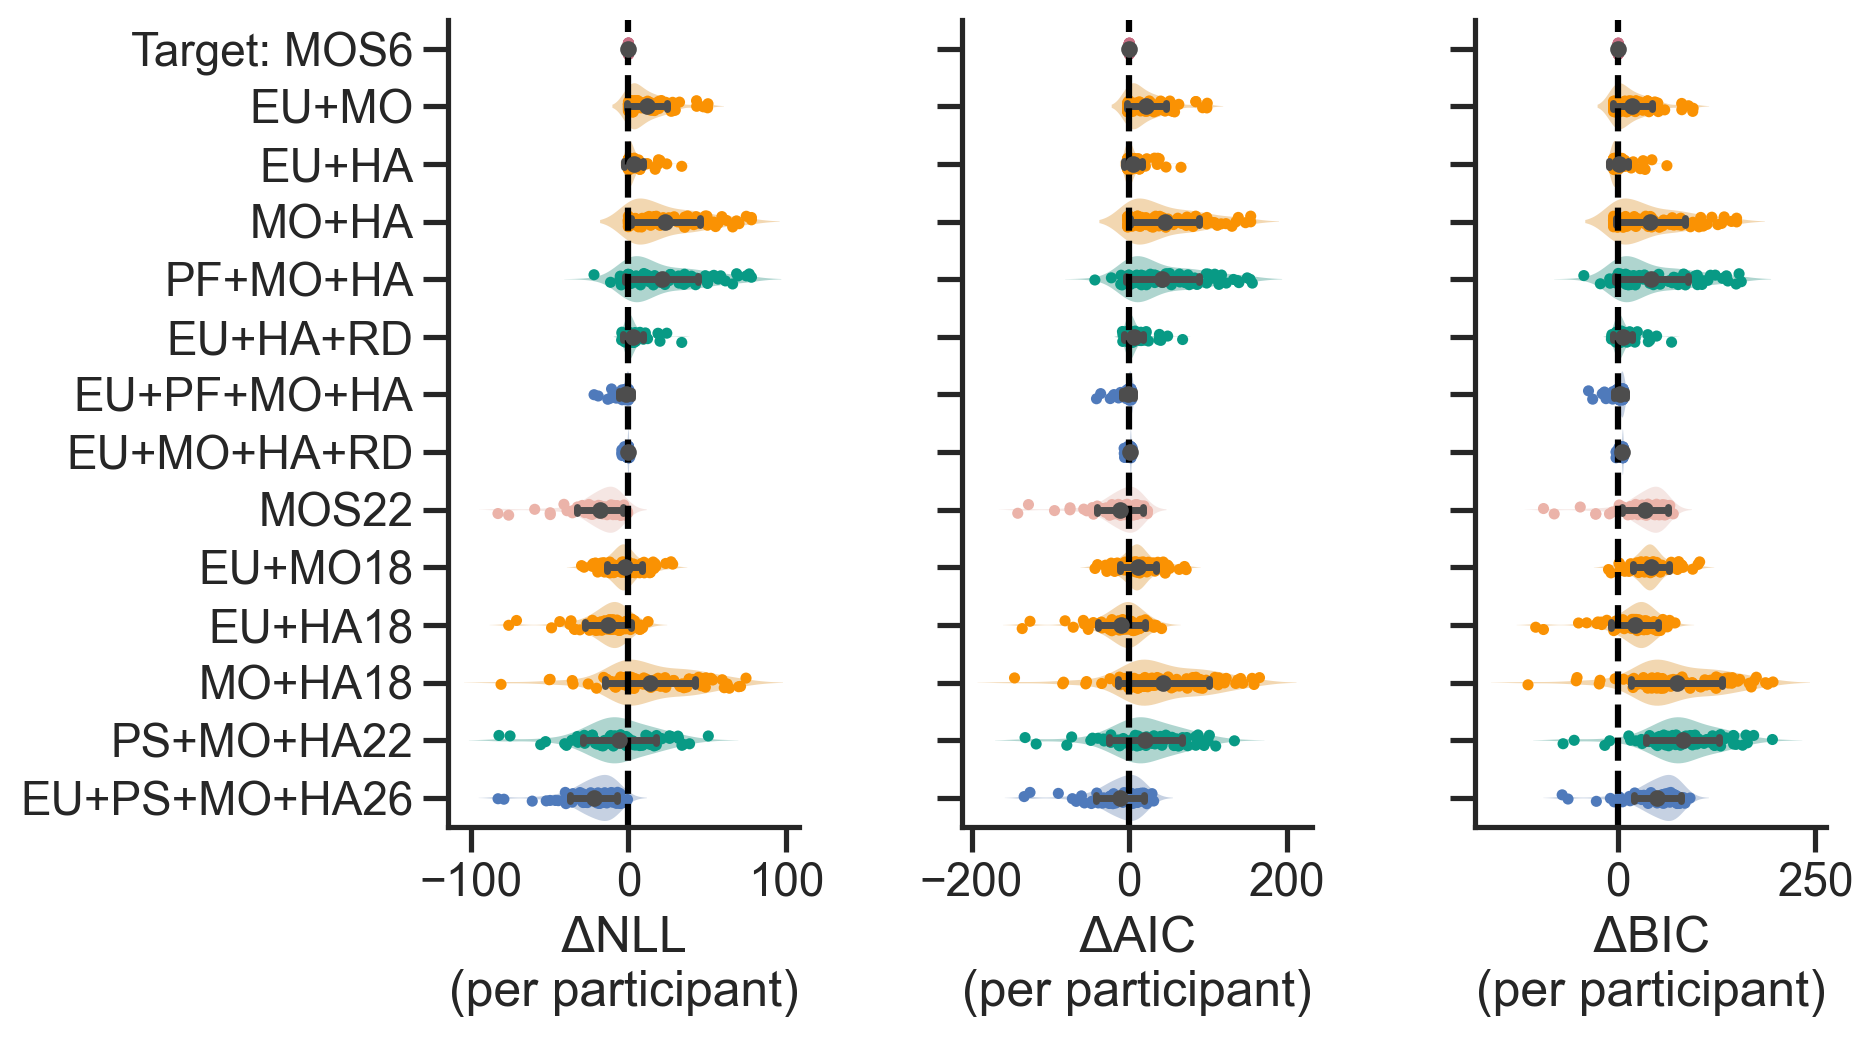

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5.5))
for fi, x_var in enumerate(['NLL', 'AIC', 'BIC']):
        ax = axs[fi]
        #x_var = 'BIC'
        tar   = 'model'
        sel_data = crs
        palette = [eval(m).color for m in models]
        viz.violin(ax, data=sel_data, y=tar,
                   x=x_var, order=models, orient='h',
                   errorbar='sd',
                   palette=palette, scatter_size=4)
        ax.axvline(x=0, ymin=0, ymax=1, color='k', ls='--')
        lbl = [eval(m).name for m in models]
        lbl.pop(0)
        lbl.insert(0, 'Target: MOS6')
        ax.set_yticklabels(lbl) if fi==0 else ax.set_yticklabels('')
        ax.set_xlabel(r'$\Delta$'+f'{x_var}\n(per participant)')
        ax.set_ylabel('')
        ax.set_box_aspect(2.3)
fig.tight_layout()
plt.savefig('../figures/FigS3-S1_MOS_select.pdf', dpi=300)